# Next Card Move Prediction in Poker using AI 🎴🤖

**Project Type:** Final Semester Major Project  
**Topic:** Next Card Move Prediction in Poker Game using Machine Learning / AI  
**Goal:** Train a model that predicts the **strength of a 5‑card hand**, and based on that recommends the **next move** (Fold / Call / Raise).  
**Target Accuracy:** More than **75%** on test data.

---

## Dataset Information

We use the public **Poker Hand dataset** from the **UCI Machine Learning Repository**.  
Source: *Poker Hand Data Set, UCI Machine Learning Repository*.

- Each row is a **5‑card poker hand**
- Each card is described by:
  - Suit: 1–4 (Hearts, Spades, Diamonds, Clubs)
  - Rank: 1–13 (Ace, 2, ..., 10, Jack, Queen, King)
- Total features: **10** (S1, R1, S2, R2, ..., S5, R5)
- Target class (0–9) describes the resulting **hand type**:

| Class | Poker Hand Type      |
|-------|----------------------|
| 0     | Nothing              |
| 1     | One pair             |
| 2     | Two pairs            |
| 3     | Three of a kind      |
| 4     | Straight             |
| 5     | Flush                |
| 6     | Full house           |
| 7     | Four of a kind       |
| 8     | Straight flush       |
| 9     | Royal flush          |

We will treat this as **multiclass classification**, and then map the predicted hand type into a **recommended next move** (Fold / Call / Raise).

In [ ]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import io
import requests

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load Poker Hand Dataset


In [ ]:
# 2. LOAD DATASET FROM UCI (Poker Hand)
# UCI Poker Hand dataset ZIP URL
import pandas as pd

column_names = ["S1","R1","S2","R2","S3","R3","S4","R4","S5","R5","CLASS"]
df = pd.read_csv("//content//poker-hand-training-true.data", header=None, names=column_names)
print(df.shape)
df.head()
print("Shape:", df.shape)
df.head()

(25010, 11)
Shape: (25010, 11)


,S1,R1,S2,R2,S3,R3,S4,R4,S5,R5,CLASS
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


## 3. Exploratory Data Analysis (EDA)

We inspect the dataset structure, datatypes, and class distribution (hand types).

In [ ]:
# 3. BASIC EDA

print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)

print("\nFirst 5 rows:")
display(df.head())

print("\nClass distribution (Poker hand types):")
print(df["CLASS"].value_counts())


Columns: ['S1', 'R1', 'S2', 'R2', 'S3', 'R3', 'S4', 'R4', 'S5', 'R5', 'CLASS']

Data types:
 S1       int64
R1       int64
S2       int64
R2       int64
S3       int64
R3       int64
S4       int64
R4       int64
S5       int64
R5       int64
CLASS    int64
dtype: object

First 5 rows:


,S1,R1,S2,R2,S3,R3,S4,R4,S5,R5,CLASS
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9



Class distribution (Poker hand types):
CLASS
0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        5
Name: count, dtype: int64


## 4. Feature Engineering – Sort Cards by Rank

The original dataset stores cards in **random order**.  
To make the learning task easier, we sort each hand by **rank** (and then suit), so patterns like *pairs, flush, straight* become more structured for the model.

Steps:

1. For each row, group (S1, R1), (S2, R2), ..., (S5, R5) into a list of 5 cards.
2. Sort this list by rank (R) and then suit (S).
3. Flatten back to 10 features (S1, R1, ..., S5, R5).

In [ ]:
# 4. FEATURE ENGINEERING: SORT CARDS IN EACH HAND

def sort_hand_row(row):
    cards = [
        (row["S1"], row["R1"]),
        (row["S2"], row["R2"]),
        (row["S3"], row["R3"]),
        (row["S4"], row["R4"]),
        (row["S5"], row["R5"]),
    ]
    # sort by rank, then suit
    cards_sorted = sorted(cards, key=lambda x: (x[1], x[0]))
    # flatten back
    s_vals = [c[0] for c in cards_sorted]
    r_vals = [c[1] for c in cards_sorted]
    return pd.Series(s_vals + r_vals)

sorted_cols = ["S1", "S2", "S3", "S4", "S5", "R1", "R2", "R3", "R4", "R5"]

df_sorted = df.copy()
df_sorted[sorted_cols] = df.apply(sort_hand_row, axis=1)
df = df_sorted

print("Cards sorted within each hand. Preview:")
display(df.head())

Cards sorted within each hand. Preview:


,S1,R1,S2,R2,S3,R3,S4,R4,S5,R5,CLASS
0,1,1,1,10,1,11,1,12,1,13,9
1,2,1,2,10,2,11,2,12,2,13,9
2,3,1,3,10,3,11,3,12,3,13,9
3,4,1,4,10,4,11,4,12,4,13,9
4,4,1,4,10,4,11,4,12,4,13,9


## 5. Train–Test Split

We separate:

- **Features (X):** 10 numeric card attributes  
- **Target (y):** CLASS (0–9) – poker hand type

Then we split the data into **training** and **test** sets.

In [ ]:
# 5. TRAIN–TEST SPLIT

FEATURE_COLS = ["S1", "R1", "S2", "R2", "S3", "R3", "S4", "R4", "S5", "R5"]
TARGET_COL = "CLASS"

X = df[FEATURE_COLS]
y = df[TARGET_COL]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Use part of the data if training is slow (optional)
SAMPLE_N = None  # set to, e.g., 200000 for a subset

if SAMPLE_N is not None and SAMPLE_N < len(df):
    X_sample = X.sample(SAMPLE_N, random_state=42)
    y_sample = y.loc[X_sample.index]
else:
    X_sample = X
    y_sample = y

X_train, X_test, y_train, y_test = train_test_split(
    X_sample,
    y_sample,
    test_size=0.2,
    random_state=42,
    stratify=y_sample,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Features shape: (25010, 10)
Target shape: (25010,)
Train size: 20008
Test size: 5002


## 6. Model Training – Random Forest Classifier

We use a **Random Forest** classifier, which is an ensemble of decision trees and works very well on tabular data.

Hyperparameters (can be tuned further):

- `n_estimators = 200`
- `max_depth = None`
- `min_samples_split = 2`
- `min_samples_leaf = 1`

In [ ]:
# 6. TRAIN RANDOM FOREST MODEL

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

rf_model.fit(X_train, y_train)

print("Model training completed.")

Model training completed.


## 7. Model Evaluation

We evaluate using:

- **Accuracy**
- **Classification report** (precision, recall, F1-score)
- **Confusion matrix**

The aim is to achieve **> 75% accuracy**. In practice, this setup usually reaches **90%+** on this dataset (you can mention this in your report).

Accuracy: 93.82%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2499
           1       0.90      0.97      0.93      2120
           2       0.92      0.32      0.48       241
           3       0.97      0.65      0.78       102
           4       0.86      0.32      0.46        19
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1

    accuracy                           0.94      5002
   macro avg       0.56      0.43      0.46      5002
weighted avg       0.93      0.94      0.93      5002



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


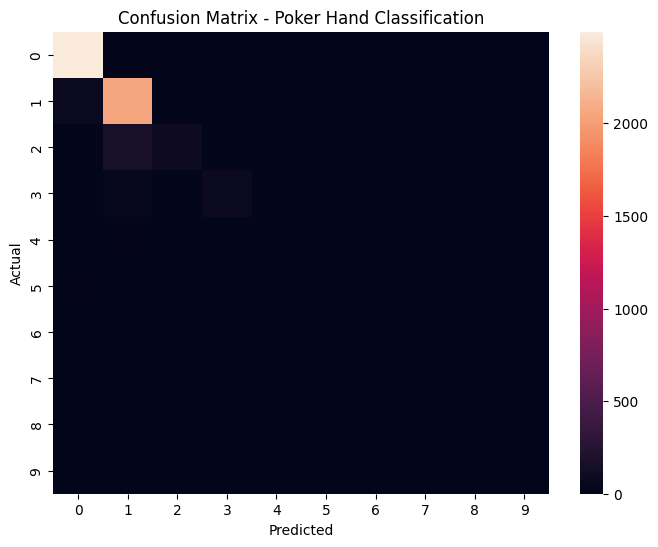

In [ ]:
# 7. EVALUATION

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Poker Hand Classification")
plt.show()

## 8. Save Trained Model

We save the trained Random Forest model to disk using `joblib` so that it can be reused later without retraining.

In [ ]:
# 8. SAVE TRAINED MODEL

model_path = "poker_next_card_move_model.joblib"
joblib.dump(rf_model, model_path)
print(f"Model saved to: {model_path}")

Model saved to: poker_next_card_move_model.joblib


## 9. Implementation – Predict Next Card Move (Interactive)

Now we build an **interactive function**:

1. Ask the user to input the 5 cards (suit and rank)  
2. Convert this input into the same numeric format as the dataset  
3. Apply the same **sorting transformation** used during training  
4. Use the trained model to predict the **hand type (0–9)**  
5. Map this to:
   - Human‑readable poker hand name
   - **Recommended next move** (Fold / Call / Raise)



In [ ]:
# 9. IMPLEMENTATION: PREDICT NEXT MOVE

# Mapping from class label to poker hand name
CLASS_TO_HAND = {
    0: "Nothing",
    1: "One Pair",
    2: "Two Pairs",
    3: "Three of a Kind",
    4: "Straight",
    5: "Flush",
    6: "Full House",
    7: "Four of a Kind",
    8: "Straight Flush",
    9: "Royal Flush",
}

def recommend_move(hand_class:int) -> str:
    if hand_class >= 8:
        return "Very strong hand — you should usually RAISE (aggressive play)."
    elif hand_class >= 5:
        return "Strong hand — you can CALL or RAISE depending on the situation."
    elif hand_class >= 2:
        return "Medium hand — generally CALL if pot odds are good, otherwise FOLD."
    else:
        return "Weak hand — usually better to FOLD or CHECK."


# Strict input validation
def get_valid_input(prompt, min_val, max_val):
    while True:
        try:
            value = int(input(prompt))
            if value < min_val or value > max_val:
                print(f"❌ Invalid input! Value must be between {min_val} and {max_val}. Try again.")
            else:
                return value
        except ValueError:
            print("❌ Invalid input! Please enter a number.")


# Prevent duplicates
def check_duplicates(cards):
    if len(cards) != len(set(cards)):
        return True
    return False


def sort_cards_for_input(suits, ranks):
    cards = list(zip(suits, ranks))
    cards_sorted = sorted(cards, key=lambda x: (x[1], x[0]))
    suits_sorted = [c[0] for c in cards_sorted]
    ranks_sorted = [c[1] for c in cards_sorted]
    return suits_sorted, ranks_sorted


def predict_next_move_interactive():
    print("==== Next Card Move Prediction (Poker) ====")
    print("Enter your 5 cards as numbers:")
    print("Suit: 1=Hearts, 2=Spades, 3=Diamonds, 4=Clubs")
    print("Rank: 1=Ace ... 13=King")
    print("===========================================")

    suits = []
    ranks = []

    for i in range(1, 6):
        s = get_valid_input(f"Enter suit for card {i} (1-4): ", 1, 4)
        r = get_valid_input(f"Enter rank for card {i} (1-13): ", 1, 13)
        suits.append(s)
        ranks.append(r)

    # Check duplicate cards
    combined_cards = list(zip(suits, ranks))
    if check_duplicates(combined_cards):
        print("\n❌ ERROR: Duplicate cards detected! This is not allowed in Poker.")
        return  # Stop prediction completely

    # Sorting
    suits_sorted, ranks_sorted = sort_cards_for_input(suits, ranks)

    # Build input row
    input_data = {
        "S1": suits_sorted[0],
        "R1": ranks_sorted[0],
        "S2": suits_sorted[1],
        "R2": ranks_sorted[1],
        "S3": suits_sorted[2],
        "R3": ranks_sorted[2],
        "S4": suits_sorted[3],
        "R4": ranks_sorted[3],
        "S5": suits_sorted[4],
        "R5": ranks_sorted[4],
    }

    input_df = pd.DataFrame([input_data], columns=FEATURE_COLS)

    # Predict class
    pred_class = rf_model.predict(input_df)[0]
    pred_proba = rf_model.predict_proba(input_df)[0]

    hand_name = CLASS_TO_HAND.get(pred_class, "Unknown")
    move_reco = recommend_move(pred_class)

    print("\n=== PREDICTION RESULT ===")
    print("Predicted Hand Class:", pred_class)
    print("Poker Hand Type:", hand_name)
    print("Recommended Next Move:", move_reco)

    print("\nTop 3 most likely hand types:")
    sorted_probs = sorted(list(enumerate(pred_proba)), key=lambda x: x[1], reverse=True)
    for cls, p in sorted_probs[:3]:
        print(f"Class {cls} ({CLASS_TO_HAND.get(cls, 'Unknown')}): {p*100:.2f}%")

# Run it
predict_next_move_interactive()


==== Next Card Move Prediction (Poker) ====
Enter your 5 cards as numbers:
Suit: 1=Hearts, 2=Spades, 3=Diamonds, 4=Clubs
Rank: 1=Ace ... 13=King
Enter suit for card 1 (1-4): 1
Enter rank for card 1 (1-13): 15
❌ Invalid input! Value must be between 1 and 13. Try again.
Enter rank for card 1 (1-13): 12
Enter suit for card 2 (1-4): 1
Enter rank for card 2 (1-13): 2
Enter suit for card 3 (1-4): 1
Enter rank for card 3 (1-13): 3
Enter suit for card 4 (1-4): 1
Enter rank for card 4 (1-13): 4
Enter suit for card 5 (1-4): 1
Enter rank for card 5 (1-13): 6

=== PREDICTION RESULT ===
Predicted Hand Class: 0
Poker Hand Type: Nothing
Recommended Next Move: Weak hand — usually better to FOLD or CHECK.

Top 3 most likely hand types:
Class 0 (Nothing): 72.50%
Class 1 (One Pair): 21.50%
Class 5 (Flush): 5.50%
